# tSNE for Donorschoose dataset

Founded in 2000 by a Bronx history teacher, DonorsChoose.org has raised $685 million for America's classrooms. Teachers at three-quarters of all the public schools in the U.S. have come to DonorsChoose.org to request what their students need, making DonorsChoose.org the leading platform for supporting public education.

DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.

Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:

a) How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible?
b) How to increase the consistency of project vetting across different volunteers to improve the experience for teachers?

Problem Objective -
The objective is to predict whether or not a project proposal presented by a teacher from DonorsChoose.org will be accepted using the project description text as well as extra metadata about the project, teacher, and school. This data can then be used by DonorsChoose.org to define projects that are most probable to require further evaluation before approval.

Attirbutes in the train.csv- 
1) project_id
2) project_title
3) project_grade_category
4) project_subject_categories
5) school_state
6) project_subject_subcategories
7) project_resource_summary
8) project_essay_1
9) project_essay_2
10) project_essay_3
11) project_essay_4
12) projecct_submitted_datetime
13) teacher_id
14) teacher_prefix
15)teacher_number_of_previously_posted_project

Attributes in resource.csv - 
Additionally, the resources.csv data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:
1) id - A project_id value from the train.csv file.
2) description - Desciption of the resource.
3) quantity - Quantity of the resource required.
4) price - Price of the resource required.

The data set contains the following label:

project_is_approved - A binary flag indicating whether DonorsChoose approved the project. A value of 0 indicates the project was not approved, and a value of 1 indicates the project was approved.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from collections import Counter

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import chart_studio.plotly as py

import matplotlib.patches as mpatches
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()

# 1) Reading data

In [2]:
train_data = pd.read_csv(r"D:\Assignments of Applied AI\Donorschoose data set\train_data.csv")
resource_data = pd.read_csv(r"D:\Assignments of Applied AI\Donorschoose data set\resources.csv")

In [3]:
print('Number of data points in the train data', train_data.shape)
print('-'*100)
print('The attributes of the data points in the train data :', train_data.columns.values)
train_data.head(2)

Number of data points in the train data (109248, 17)
----------------------------------------------------------------------------------------------------
The attributes of the data points in the train data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1

In [4]:
print('Number of data points in the train data', resource_data.shape)
print('-'*100)
print('The attributes of the data points in the resource data:', resource_data.columns.values)
resource_data.head(3)

Number of data points in the train data (1541272, 4)
----------------------------------------------------------------------------------------------------
The attributes of the data points in the resource data: ['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   

    price  
0  149.00  
1   14.95  
2    8.45

In [5]:
train_data.dtypes

Unnamed: 0                                       int64
id                                              object
teacher_id                                      object
teacher_prefix                                  object
school_state                                    object
project_submitted_datetime                      object
project_grade_category                          object
project_subject_categories                      object
project_subject_subcategories                   object
project_title                                   object
project_essay_1                                 object
project_essay_2                                 object
project_essay_3                                 object
project_essay_4                                 object
project_resource_summary                        object
teacher_number_of_previously_posted_projects     int64
project_is_approved                              int64
dtype: object

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 17 columns):
Unnamed: 0                                      109248 non-null int64
id                                              109248 non-null object
teacher_id                                      109248 non-null object
teacher_prefix                                  109245 non-null object
school_state                                    109248 non-null object
project_submitted_datetime                      109248 non-null object
project_grade_category                          109248 non-null object
project_subject_categories                      109248 non-null object
project_subject_subcategories                   109248 non-null object
project_title                                   109248 non-null object
project_essay_1                                 109248 non-null object
project_essay_2                                 109248 non-null object
project_essay_3                       

Observation - There are no missing values in this data set

In [7]:
print(list(train_data['project_is_approved'].unique()))

[0, 1]


# 2) Exploratory Data Analysis

In [8]:
y_value_counts= train_data['project_is_approved'].value_counts() 

In [9]:
print('Number of project is approved for funding', ", (" , y_value_counts[1]/float(y_value_counts[0]+y_value_counts[1])*100,"%)")
print('Number of project is not approved for funding',", (" , y_value_counts[0]/float(y_value_counts[0]+y_value_counts[1])*100, "%)")

Number of project is approved for funding , ( 84.85830404217927 %)
Number of project is not approved for funding , ( 15.141695957820739 %)


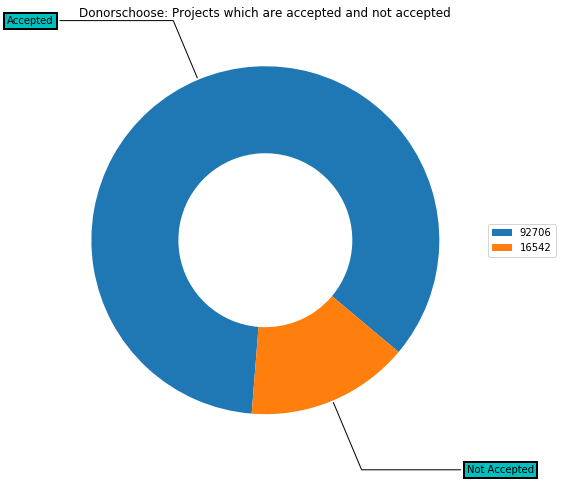

In [10]:
## https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
recipe = ['Accepted', 'Not Accepted']
data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)
bbox_props = dict(boxstyle = 'square, pad = 0.3', fc = 'c', ec = 'k', lw = 2)
kw = dict(xycoords = 'data', textcoords = 'data', arrowprops = dict(arrowstyle = '-'),
         bbox=bbox_props, zorder = 0, ha = 'center', va = 'top')

for i, p in enumerate (wedges):
    ang = (p.theta2 - p.theta1)/2 +p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Donorschoose: Projects which are accepted and not accepted")
ax.legend(data, loc = 'center left', bbox_to_anchor=(1, 0, 0, 1))


plt.show()

In [11]:
train_data.describe()

Unnamed: 0  teacher_number_of_previously_posted_projects  \
count  109248.000000                                 109248.000000   
mean    91183.786568                                     11.153165   
std     52548.095272                                     27.777154   
min         0.000000                                      0.000000   
25%     45743.500000                                      0.000000   
50%     91253.500000                                      2.000000   
75%    136712.500000                                      9.000000   
max    182079.000000                                    451.000000   

       project_is_approved  
count        109248.000000  
mean              0.848583  
std               0.358456  
min               0.000000  
25%               1.000000  
50%               1.000000  
75%               1.000000  
max               1.000000

### 2.1) Univariate analysis - school state

In [12]:
#https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('projects')
    plt.title('Number of project accepted vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [13]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    #train.plt(kind='bar', stacked=True);
    train = pd.DataFrame(train_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()
 
    #Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    train['total'] = pd.DataFrame(train_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    train['Avg'] = pd.DataFrame(train_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    train.sort_values(by=['total'],inplace=True, ascending=False)
   
    if top:
        train = train[0:top]
        
    
    stack_plot(train, xtick=col1, col2= col2, col3='total')
    print(train.head(5))
    print('='*100)
    print(train.tail(5))

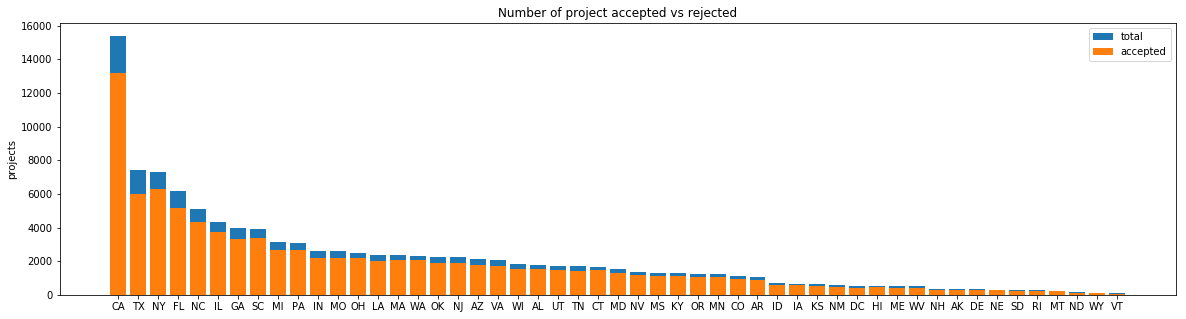

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [14]:
univariate_barplots(train_data, 'school_state', 'project_is_approved', False)

observation - 
1) The majority of the project is endorsed in the state of California(CA) with an average of 85.81% and the lowest in the state of Vermont(VT) with an average of 80.00%.
2) In the average acceptance rate of project approval across countries, we discovered a lot of variability from the above table.
3) In the United States, each country has a project approval rate of more than 80%.

In [15]:
train = pd.DataFrame(train_data.groupby('school_state')["project_is_approved"].apply(np.mean)).reset_index() 

In [16]:
train.sort_values(by=['project_is_approved'], inplace = True)
print('States with lowest percentage approvals')
print(train.head(5))
print('*'*100)
print('States with highest percentage approvals')
print(train.tail(5))

States with lowest percentage approvals
   school_state  project_is_approved
46           VT             0.800000
7            DC             0.802326
43           TX             0.813142
26           MT             0.816327
18           LA             0.831245
****************************************************************************************************
States with highest percentage approvals
   school_state  project_is_approved
30           NH             0.873563
35           OH             0.875152
47           WA             0.876178
28           ND             0.888112
8            DE             0.897959


Observation - 
1)Vermont State (VT) has the smallest proportion of project approvals, i.e. 80%, followed by District of Columbia (DC) with 80.83% and Texas (TX) with 81.31% in the U.S.
2) Delaware State (DE) has the largest proportion of project approvals, i.e. 89.79%, followed by North Dakota (ND) with 88.81% and Washington (WA) with 87.61% in the U.S.

In [17]:
#https://datascience.stackexchange.com/questions/9616/how-to-create-us-state-heatmap
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = train['school_state'],
        z = train['project_is_approved'].astype(float),
        locationmode = 'USA-states',
        text = train['school_state'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')

### 2.2) Univariate analysis - Teacher prefix

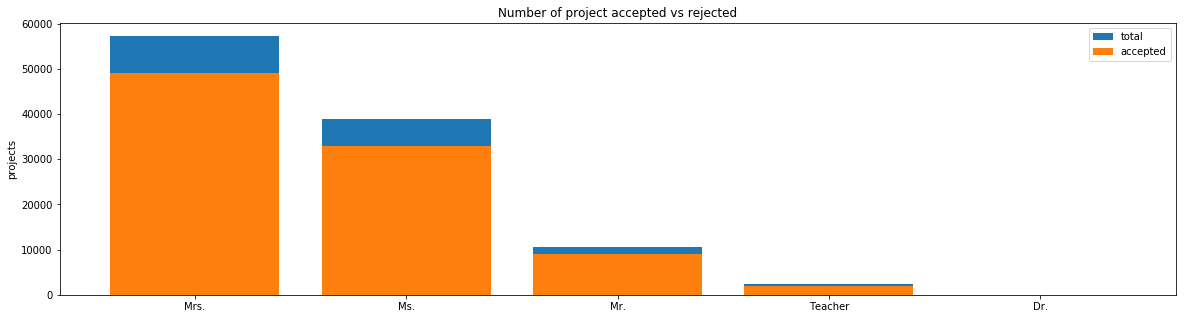

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [18]:
univariate_barplots(train_data, 'teacher_prefix', 'project_is_approved', False)

Observation - 
1. Female teachers have suggested and accepted the highest amount of projects compared with male teachers.
2. Teachers with Mrs. prefixes meaning Married Women as teachers have a greater amount of projects being proposed and accepted compared to younger Unmarried Women Teachers.
3. Rarely 13 projects have been suggested by Dr. title teachers and 9 of them have been endorsed.

### 2.3) Univariate analysis - Project grade category

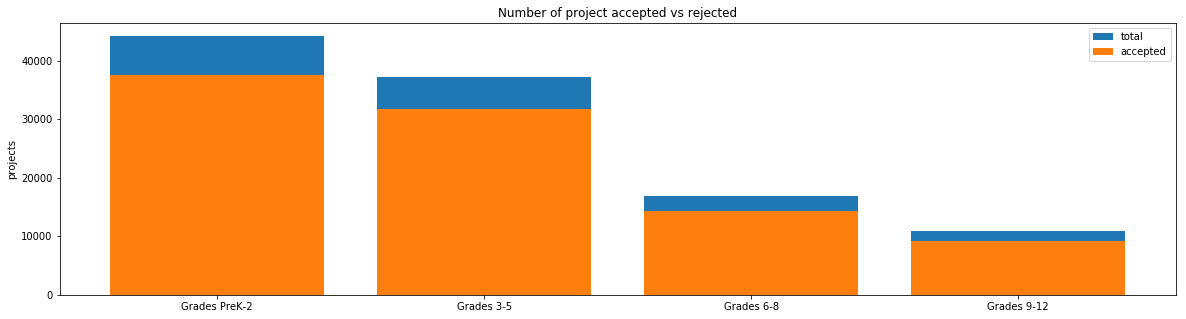

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [19]:
univariate_barplots(train_data, 'project_grade_category', 'project_is_approved', False)

Observation - 
1. Between Pre Kindergarden and 2nd Grade, there are many projects suggested for the students while it continues to decline for the remainder.
2. The project's average acceptance rate is 84 percent regardless of the grade.
3. We also notice that the smallest amount of projects suggested and approved by students between the 9th and 12th grades.

### 2.4) Univariate Analysis : project_subject_categories

In [20]:
pro_sub_catogories = list(train_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
pro_sub_cat_list = []
for i in pro_sub_catogories:
    train = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        train+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        train = train.replace('&','_') # we are replacing the & value into 
    pro_sub_cat_list.append(train.strip())

In [21]:
train_data['clean_categories'] = pro_sub_cat_list
train_data.drop(['project_subject_categories'], axis=1, inplace=True)
train_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

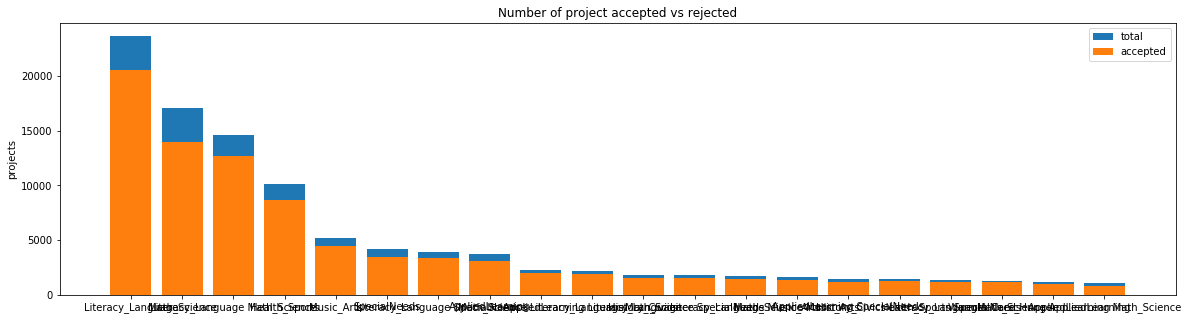

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [22]:
univariate_barplots(train_data, 'clean_categories', 'project_is_approved', top=20)

Observation - 
1. Projects belonging to the categories of Literacy and Language have the largest amount of suggested initiatives. This category also includes the highest amount of approved projects, with an acceptance rate of approximately 87%.
2. Projects belonging to both mathematics and science have an acceptance rate of almost 82%, while introducing the notion of literacy and language can boost their accomplishment rate to almost 87%.
3. The complete amount of projects suggested by project category varies greatly.
4. There is also variability in the acceptance rate, projects in the Warmth, Care and Hunger category have a 93.5 percent acceptance rate


In [23]:
from collections import Counter
my_counter = Counter()
for word in train_data['clean_categories'].values:
    my_counter.update(word.split())

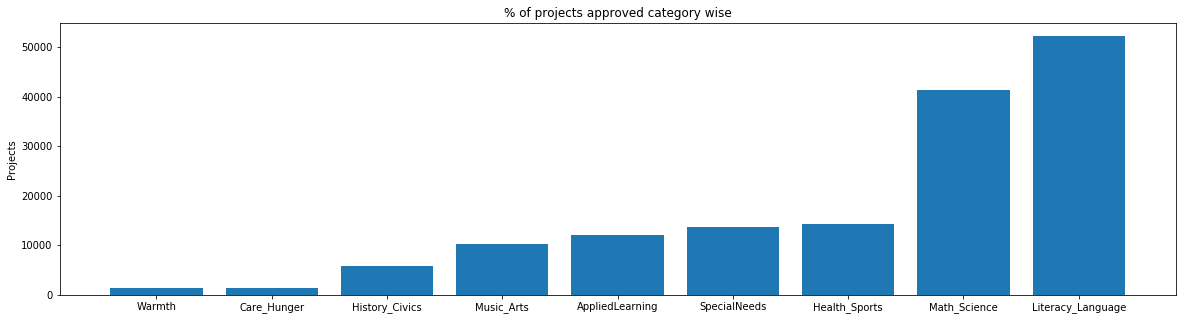

In [24]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
pro_sub_cat_dict = dict(my_counter)
sorted_pro_sub_cat_dict = dict(sorted(pro_sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_pro_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_pro_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects approved category wise')
plt.xticks(ind, list(sorted_pro_sub_cat_dict.keys()))
plt.show()

In [25]:
for i, j in sorted_pro_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


Observation - 
1. The largest amount of projects are recorded with 52,239 projects in Literacy and Language, followed by 41,421 projects in Maths and Science.
2. In the Warmth, Care or Hunger category, there are only 1388 projects.

### 2.5) Univariate analysis - Project_subject_subcategories

In [26]:
pro_sub_subcatogories = list(train_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

pro_sub_subcat_list = []
for i in pro_sub_subcatogories:
    train = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        train +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        train = train.replace('&','_')
    pro_sub_subcat_list.append(train.strip())

In [27]:
train_data['clean_subcategories'] = pro_sub_subcat_list
train_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
train_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

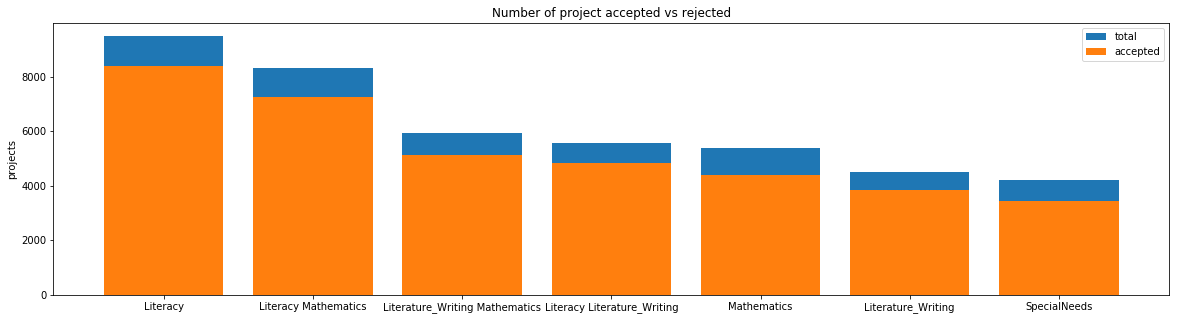

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                clean_subcategories  project_is_approved  total       Avg
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
330              Literature_Writing                 3846   4501  0.854477
392                    SpecialNeeds                 3431   4226  0.811879


In [28]:
univariate_barplots(train_data, 'clean_subcategories', 'project_is_approved', top=7)

Observation - 
With 8371 projects, the Literacy sub-category has the largest amount of projects authorized. The acceptance rate is also 88%.

In [29]:
from collections import Counter
my_counter = Counter()
for word in train_data['clean_subcategories'].values:
    my_counter.update(word.split())

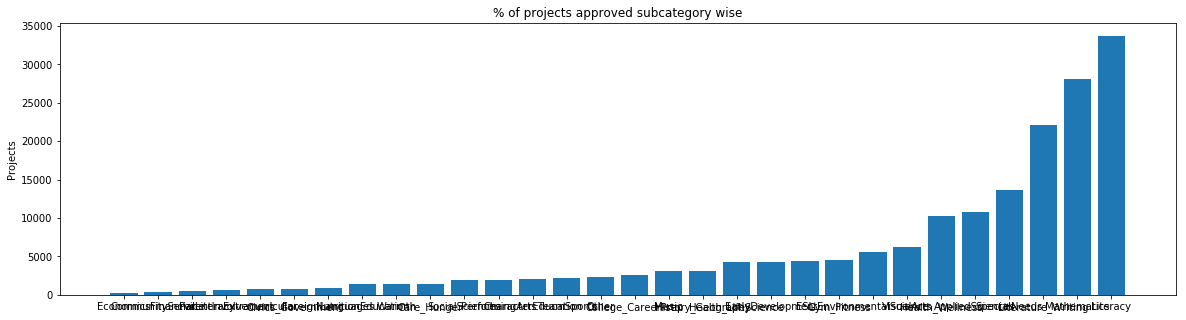

In [30]:
pro_sub_subcat_dict = dict(my_counter)
sorted_pro_sub_subcat_dict = dict(sorted(pro_sub_subcat_dict.items(), key=lambda kv: kv[1]))

ind = np.arange(len(sorted_pro_sub_subcat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_pro_sub_subcat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects approved subcategory wise')
plt.xticks(ind, list(sorted_pro_sub_subcat_dict.keys()))
plt.show()

In [31]:
for i, j in sorted_pro_sub_subcat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


### 2.6) Univariate Analysis: Text features(Project Title)

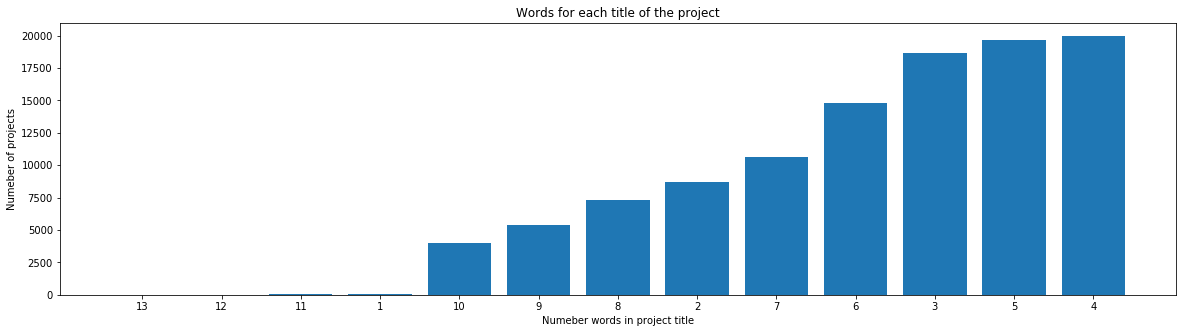

In [32]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
pro_word_count = train_data['project_title'].str.split().apply(len).value_counts()
pro_word_dict = dict(pro_word_count)
pro_word_dict = dict(sorted(pro_word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(pro_word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(pro_word_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(pro_word_dict.keys()))
plt.show()

Observation - 
Most of the projects are titled with 4 words. Similarly, in most of the project there are also 3 and 5 words. Few of the parts of the project contain 10 words in the name.

In [33]:
approved_title_word_count = train_data[train_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = train_data[train_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

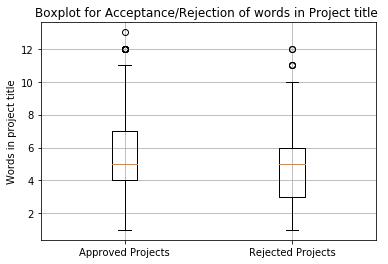

In [34]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.title('Boxplot for Acceptance/Rejection of words in Project title ')
plt.grid()
plt.show()

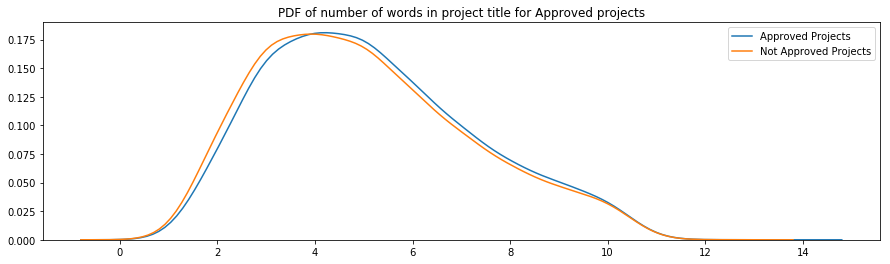

In [35]:
plt.figure(figsize=(15,4))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.title('PDF of number of words in project title for Approved projects')
plt.legend()
plt.show()

Observation - 
Compared to the Rejected Projects, the amount of Projects authorized has a slightly greater amount of words in the Title. The Box plots use the percentiles while the graph above used densities of probability.

### 2.7) Univariate Analysis: Text features(Project Essay)

In [36]:
# merge two column text dataframe: 
train_data["essay"] = train_data["project_essay_1"].map(str) + train_data["project_essay_2"].map(str) + \
                        train_data["project_essay_3"].map(str) + train_data["project_essay_4"].map(str)

In [37]:
approved_word_count = train_data[train_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = train_data[train_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

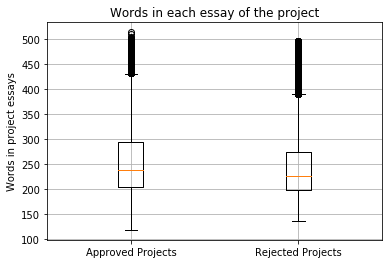

In [38]:
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words in each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()

Observation - 
In project essays, authorized projects have a slightly higher amount of words compared to projects that were not approved. This distinction can be seen in the gap after the 50.0 percentile.

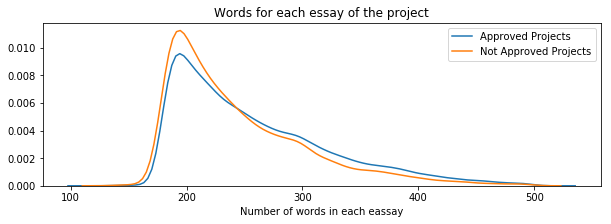

In [39]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

Observation - 
The amount of words in the approved project essays is slightly higher than the amount of words in the rejected project essays. This can be observed by looking at the Blue Line (Approved Projects PDF Curve) which is more dense for words than 240 to nearly 480 or 500.


### 2.8) Univariate analysis - cost per project

In [40]:
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [41]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [42]:
train_data = pd.merge(train_data, price_data, on='id', how='left')

In [43]:
approved_price = train_data[train_data['project_is_approved']==1]['price'].values
rejected_price = train_data[train_data['project_is_approved']==0]['price'].values

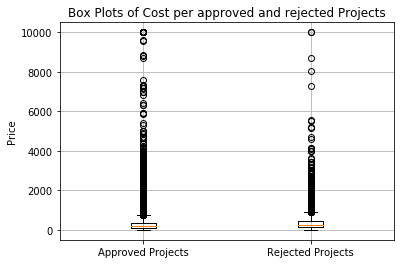

In [44]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and rejected Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

In [45]:
plt.figure(figsize=(15,4))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and rejected Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

Observation - 
From the box plot presenting the cost engaged per project, not much can be understood. From the PDF curves, we can generalize that mostly very expensive projects are not generally approved.

In [46]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

Observation - 
1. The authorized projects tend to have reduced costs compared to non-approved projects. Looking at the percentile values, this can be noticed. For an approved project, the 50th percentile cost value is $198.99, while the cost for the unapproved projects is $263.145.
2. The maximum cost should be less than 10,000 dollars for any project.
3. Any authorized project typically costs less than the Projects not authorized across the percentile spectrum.

### 2.9) Univariate analysis: teacher_number of previously posted projects

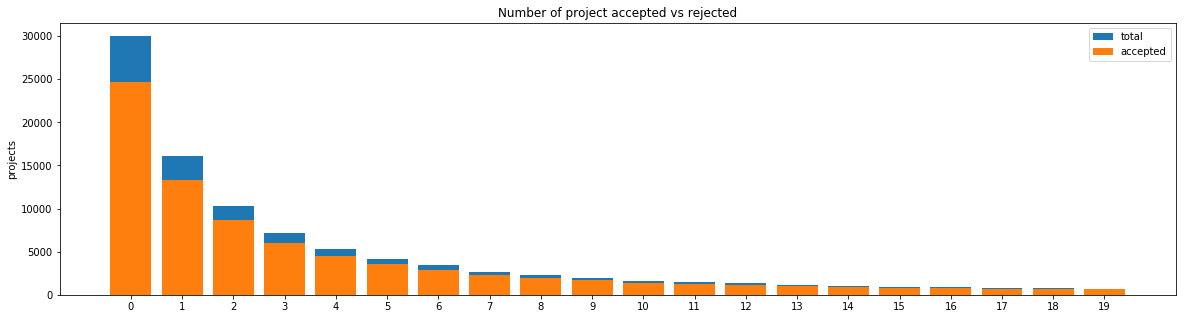

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                24652  30014   
1                                             1                13329  16058   
2                                             2                 8705  10350   
3                                             3                 5997   7110   
4                                             4                 4452   5266   

        Avg  
0  0.821350  
1  0.830054  
2  0.841063  
3  0.843460  
4  0.845423  
    teacher_number_of_previously_posted_projects  project_is_approved  total  \
15                                            15                  818    942   
16                                            16                  769    894   
17                                            17                  712    803   
18                                            18                  666    772   
19                                       

In [47]:
univariate_barplots(train_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved', top=20)

Observation - 
1. The amount of projects earlier suggested by the teacher varies considerably from 0 to more than 20.
2. We note that a teacher does not have to propose any project beforehand. Teachers with no previous project proposals presented a maximum amount of teachers, almost 82 percent of the authorized projects. There is much appreciation for new talent and attempts.
3. Approval has been given to very few teachers who have suggested more than 20 projects. But, considering that the teacher has proposed at least 19 distinct projects, the approval rate is higher.

### 2.10) Univariate analysis: project_resource_summary

In [48]:
#separate the data and carry out our work only on the required Project Resource Summaries.

summaries = []

for a in train_data["project_resource_summary"] :
    summaries.append(a)
    
summaries[0:10]

['My students need opportunities to practice beginning reading skills in English at home.',
 'My students need a projector to help with viewing educational programs',
 'My students need shine guards, athletic socks, Soccer Balls, goalie gloves, and training materials for the upcoming Soccer season.',
 'My students need to engage in Reading and Math in a way that will inspire them with these Mini iPads!',
 'My students need hands on practice in mathematics. Having fun and personalized journals and charts will help them be more involved in our daily Math routines.',
 'My students need movement to be successful. Being that I have a variety of students that have all different types of needs, flexible seating would assist not only these students with special needs, but all students.',
 'My students need some dependable laptops for daily classroom use for reading and math.',
 'My students need ipads to help them access a world of online resources that will spark their interest in learning.',

In [49]:
len(summaries)

109248

In [50]:
numeric_summary_values = {}

for x in tqdm(range(len(summaries))):
    for s in summaries[x].split():
        if s.isdigit() :
            numeric_summary_values[x] = int(s)

100%|██████████████████████████████| 109248/109248 [00:00<00:00, 184218.77it/s]


In [51]:
numeric_summary_values[14]

5

In [52]:
numeric_digits ={}

for c in range(len(summaries)):
    if c in numeric_summary_values.keys():
        numeric_digits[c] = numeric_summary_values[c]
    else:
        numeric_digits[c] = 0

In [53]:
len(numeric_digits)

109248

In [54]:
digit_in_summary = []
for a in numeric_digits.values() :
    if a > 0 :
        digit_in_summary.append(1)
    else :
        digit_in_summary.append(0)

In [55]:
digit_in_summary[0:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]

In [56]:
train_data ["digit_in_summary"] = digit_in_summary

In [57]:
train_data.head(20)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0       160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1       140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2        21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3           45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4       172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   
5       141660  p154343  a50a390e8327a95b77b9e495b58b9a6e           Mrs.   
6        21147  p099819  9b40170bfa65e399981717ee8731efc3           Mrs.   
7        94142  p092424  5bfd3d12fae3d2fe88684bbac570c9d2            Ms.   
8       112489  p045029  487448f5226005d08d36bdd75f095b31           Mrs.   
9       158561  p001713  140eeac1885c820ad5592a409a3a8994            Ms.   
10       43184  p040307  363788b51d40d978fe276bcb1f8a2b35           Mrs.   
11      127083  p251806  4ba7c721133ef651ca54a03551746708            Ms.   
12       19090  p051126  5e52c92b7e3c472aad247a239d345543           Mrs.   
13       15126  p003874  178f6ae765cd4e0fb143a77c47fd65e2           Mrs.   
14       62232  p233127  424819801de22a60bba7d0f4354d0258            Ms.   
15       67303  p132832  bb6d6d054824fa01576ab38dfa2be160            Ms.   
16      127215  p174627  4ad7e280fddff889e1355cc9f29c3b89           Mrs.   
17      157771  p152491  e39abda057354c979c5b075cffbe5f88            Ms.   
18      122186  p196421  fcd9b003fc1891383f340a89da02a1a6           Mrs.   
19      146331  p058343  8e07a98deb1bc74c75b97521e05b1691            Ms.   

   school_state project_submitted_datetime project_grade_category  \
0            IN        2016-12-05 13:43:57          Grades PreK-2   
1            FL        2016-10-25 09:22:10             Grades 6-8   
2            AZ        2016-08-31 12:03:56             Grades 6-8   
3            KY        2016-10-06 21:16:17          Grades PreK-2   
4            TX        2016-07-11 01:10:09          Grades PreK-2   
5            FL        2017-04-08 22:40:43             Grades 3-5   
6            CT        2017-02-17 19:58:56             Grades 6-8   
7            GA        2016-09-01 00:02:15             Grades 3-5   
8            SC        2016-09-25 17:00:26          Grades PreK-2   
9            NC        2016-11-17 18:18:56          Grades PreK-2   
10           CA        2017-01-04 16:40:30             Grades 3-5   
11           CA        2016-11-14 22:57:28          Grades PreK-2   
12           NY        2016-05-23 15:46:02             Grades 6-8   
13           OK        2016-10-17 09:49:27          Grades PreK-2   
14           MA        2017-02-14 16:29:10          Grades PreK-2   
15           TX        2016-10-05 21:05:38             Grades 3-5   
16           FL        2017-01-18 10:59:05          Grades PreK-2   
17           NV        2016-11-23 17:14:17             Grades 3-5   
18           GA        2016-08-28 15:04:42          Grades PreK-2   
19           OH        2016-08-06 13:05:20             Grades 3-5   

                                        project_title  \
0    Educational Support for English Learners at Home   
1               Wanted: Projector for Hungry Learners   
2   Soccer Equipment for AWESOME Middle School Stu...   
3                              Techie Kindergarteners   
4                              Interactive Math Tools   
5   Flexible Seating for Mrs. Jarvis' Terrific Thi...   
6   Chromebooks for Special Education Reading Program   
7                               It's the 21st Century   
8                     Targeting More Success in Class   
9     Just For the Love of Reading--\r\nPure Pleasure   
10                              Reading Changes Lives   
11  Elevating Academics and Parent Rapports Throug...   
12                  Building Life Science Experiences   
13                     Everyone deserves to be heard!   
14                      TABLETS CAN SHOW US THE WORLD   
15                               Making Reces

In [58]:
univariate_barplots(train_data, 'digit_in_summary', 'project_is_approved', top=2)

   digit_in_summary  project_is_approved  total       Avg
0                 0                82563  98012  0.842376
1                 1                10143  11236  0.902723
   digit_in_summary  project_is_approved  total       Avg
0                 0                82563  98012  0.842376
1                 1                10143  11236  0.902723


Observation - 
1. From the graph it is evident that most projects do not have numerical values that state the necessity of certain products.
2. The numerical project summaries have a very elevated acceptability rate of 90%. Well, adequate numbered requirements indicate clarity in the suggestions and therefore many individuals tend to donate for a better cause, i.e. helping kids.

# 3) Text Preprocessing

### 3.1) Essay Text

In [59]:
train_data.head(5)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2        ...         \
0  \"The limits of your language are the limits o...        ...          
1  The projector we need for our school is very c...        ...          
2  The students on the campus come to school know...        ...          
3  My students live in high poverty conditions wi...        ...          
4  For many students, math is a subject that does...        ...          

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            0                    0   
1                                            7                    1   
2                                            1                    0   
3                                            4                    1   
4                                            1                    1   

                 clean_categories           clean_subcategories  \
0               Literacy_Language                  ESL Literacy   
1    History_Civics Health_Sports  Civics_Government TeamSports   
2                   Health_Sports    Health_Wellness TeamSports   
3  Literacy_Language Math_Science          Literacy Mathematics   
4                    Math_Science                   Mathematics   

                                               essay   price  quantity  \
0  My students are English learners that are work...  154.60        23   
1  Our students arrive to our school eager to lea...  299.00         1   
2  \r\n\"True champions aren't always the ones th...  516.85        22   
3  I work at a unique school filled with both ESL...  232.90         4   
4  Our second grade classroom next year will be m...   67.98         4   

   digit_in_summary  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  

[5 rows x 21 columns]

In [60]:
print(train_data['essay'].values[0])
print('='*127)
print(train_data['essay'].values[150])
print('='*127)
print(train_data['essay'].values[1000])
print('='*127)
print(train_data['essay'].values[20000])
print('='*127)
print(train_data['essay'].values[99999])
print('='*127)

My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [61]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [62]:
sent = decontracted(train_data['essay'].values[20000])
print(sent)
print("="*127)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [63]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [64]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [65]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]


In [66]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []

# tqdm is for printing the status bar
for sentance in tqdm(train_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())


100%|████████████████████████████████| 109248/109248 [01:27<00:00, 1244.06it/s]


In [67]:
preprocessed_essays[1000]

'how remember days school was sterile environment plain walls rows desks teacher front room a typical day room nothing like i work hard create warm inviting themed room students look forward coming day my class made 28 wonderfully unique boys girls mixed races arkansas they attend title i school means high enough percentage free reduced price lunch qualify our school open classroom concept unique no walls separating classrooms these 9 10 year old students eager learners like sponges absorbing information experiences keep wanting with resources comfy red throw pillows whimsical nautical hanging decor blue fish nets i able help create mood classroom setting one themed nautical environment creating classroom environment important success every child education the nautical photo props used child step foot classroom first time meet teacher evening i take pictures child developed hung classroom ready first day 4th grade this kind gesture set tone even first day school the nautical thank card

In [68]:
print(train_data['project_title'].values[0])
print("="*50)
print(train_data['project_title'].values[150])
print("="*50)
print(train_data['project_title'].values[1000])
print("="*50)
print(train_data['project_title'].values[20000])
print("="*50)
print(train_data['project_title'].values[99999])
print("="*50)

Educational Support for English Learners at Home
More Movement with Hokki Stools
Sailing Into a Super 4th Grade Year
We Need To Move It While We Input It!
Inspiring Minds by Enhancing the Educational Experience


In [69]:
preprocessed_titles = []

for titles in tqdm(train_data["project_title"]):
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    title = ' '.join(f for f in title.split() if f not in stopwords)
    preprocessed_titles.append(title.lower().strip())

100%|███████████████████████████████| 109248/109248 [00:04<00:00, 25043.96it/s]


In [70]:
print(preprocessed_titles[0])
print("="*50)
print(preprocessed_titles[150])
print("="*50)
print(preprocessed_titles[1000])
print("="*50)
print(preprocessed_titles[20000])
print("="*50)
print(preprocessed_titles[99999])
print("="*50)

educational support english learners home
more movement hokki stools
sailing into super 4th grade year
we need to move it while we input it
inspiring minds enhancing educational experience


In [71]:
train_data.project_grade_category = train_data.project_grade_category.str.replace('\s','_')
train_data['project_grade_category'].value_counts()
train_data.project_grade_category = train_data.project_grade_category.str.replace('-','_')
train_data['project_grade_category'].value_counts()

Grades_PreK_2    44225
Grades_3_5       37137
Grades_6_8       16923
Grades_9_12      10963
Name: project_grade_category, dtype: int64

# 4) Preparing data for models

In [72]:
train_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'digit_in_summary'],
      dtype='object')

## 4.1) Vectorizing the categorical data by One hot encoding (subject categories, subject subcategories, school state, Teacher prefix, project grade category)

In [73]:
#Use count vectorizer to convert the values into one hot encoded features

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary=list(sorted_pro_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(train_data['clean_categories'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(train_data['clean_categories'].values)
print("Shape of matrix after one hot encoding ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encoding  (109248, 9)


In [74]:
vectorizer = CountVectorizer(vocabulary=list(sorted_pro_sub_subcat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(train_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot = vectorizer.transform(train_data['clean_subcategories'].values)
print("Shape of matrix after one hot encoding ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encoding  (109248, 30)


In [75]:
my_counter = Counter()
for state in train_data['school_state'].values:
    my_counter.update(state.split())

In [76]:
school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))

In [77]:
vectorizer = CountVectorizer(vocabulary=list(sorted_school_state_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(train_data['school_state'].values)
print(vectorizer.get_feature_names())

school_state_categories_one_hot = vectorizer.transform(train_data['school_state'].values)
print("Shape of matrix after one hot encoding ",school_state_categories_one_hot.shape)

['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']
Shape of matrix after one hot encoding  (109248, 51)


In [78]:
my_counter = Counter()
for teacher_prefix in train_data['teacher_prefix'].values:
    teacher_prefix = str(teacher_prefix)
    my_counter.update(teacher_prefix.split())

In [79]:
teacher_prefix_cat_dict = dict(my_counter)
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1]))

In [80]:
## https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document/39308809#39308809

vectorizer = CountVectorizer(vocabulary=list(sorted_teacher_prefix_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(train_data['teacher_prefix'].values.astype("U"))
print(vectorizer.get_feature_names())

teacher_prefix_categories_one_hot = vectorizer.transform(train_data['teacher_prefix'].values.astype("U"))
print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot.shape)


['nan', 'Dr.', 'Teacher', 'Mr.', 'Ms.', 'Mrs.']
Shape of matrix after one hot encoding  (109248, 6)


In [81]:
my_counter = Counter()
for project_grade_category in train_data['project_grade_category'].values:
    my_counter.update(project_grade_category.split())

In [82]:
from operator import itemgetter
project_grade_cat_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(project_grade_cat_dict.items(), key=lambda kv: kv[0], reverse = True))

In [83]:
vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(train_data['project_grade_category'].values)
print(vectorizer.get_feature_names())

project_grade_categories_one_hot = vectorizer.transform(train_data['project_grade_category'].values)
print("Shape of matrix after one hot encoding ",project_grade_categories_one_hot.shape)

['Grades_PreK_2', 'Grades_9_12', 'Grades_6_8', 'Grades_3_5']
Shape of matrix after one hot encoding  (109248, 4)


# 4.2) Vectorizing the text data

### 4.2.1) Bag of words

In [84]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encoding ",text_bow.shape)

Shape of matrix after one hot encoding  (109248, 16623)


In [85]:
print("There are {} unique words among the {} number of Project essays, considering atleast 10 different projects has the same word"\
      .format(text_bow.shape[1], text_bow.shape[0]))

There are 16623 unique words among the 109248 number of Project essays, considering atleast 10 different projects has the same word


In [86]:
# We are considering only the words which appeared in at least 5 documents(rows or projects).
vectorizer = CountVectorizer(min_df=5)
title_bow = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encoding ",title_bow.shape)

Shape of matrix after one hot encoding  (109248, 5107)


In [87]:
print ("There are {} unique words among the {} number of project titles, considering atleast 5 different projects has the same word "\
       .format(title_bow.shape[1], title_bow.shape[0]))

There are 5107 unique words among the 109248 number of project titles, considering atleast 5 different projects has the same word 


### 4.2.2) TfIDF vectorizer

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encoding ",text_tfidf.shape)

Shape of matrix after one hot encoding  (109248, 16623)


In [89]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = TfidfVectorizer(min_df=5)
title_tfidf = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encoding ",title_tfidf.shape)

Shape of matrix after one hot encoding  (109248, 5107)


### 4.2.3) Using Pre trained models: AvgW2V

In [90]:
with open (r'C:\Users\lenovo\Downloads\glove_vectors', "rb") as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

In [91]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))


100%|████████████████████████████████| 109248/109248 [00:50<00:00, 2146.80it/s]


109248
300


In [92]:
# Similarly you can vectorize for title also

avg_w2v_vectors_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles.append(vector)

print(len(avg_w2v_vectors_titles))
print(len(avg_w2v_vectors_titles[0]))

100%|███████████████████████████████| 109248/109248 [00:03<00:00, 31821.08it/s]


109248
300


### 4.2.4) Using Pre trained models:  weighted W2V

In [93]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [94]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))


100%|█████████████████████████████████| 109248/109248 [06:31<00:00, 279.16it/s]


109248
300


In [95]:
# Similarly you can vectorize for title also

tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [96]:
# average Word2Vec
# compute average word2vec for each Project Title
tfidf_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_title.append(vector)

print(len(tfidf_w2v_vectors_title))
print(len(tfidf_w2v_vectors_title[0]))


100%|███████████████████████████████| 109248/109248 [00:07<00:00, 13779.23it/s]


109248
300


### 4.3) Vectorizing numerical data

#### 4.3.1) On Price data

In [97]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(train_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print("Mean : {}".format(price_scalar.mean_[0]))
print("Standard deviation : {}".format(np.sqrt(price_scalar.var_[0])))
# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(train_data['price'].values.reshape(-1, 1))

Mean : 298.1193425966608
Standard deviation : 367.49634838483496


In [98]:
price_standardized

array([[-0.3905327 ],
       [ 0.00239637],
       [ 0.59519138],
       ...,
       [-0.15825829],
       [-0.61243967],
       [-0.51216657]])

###### Observation - 
We notice that an average cost almost 298 dollars each project, with a standard deviation of 368 dollars. So, most of the projects are less than 750 dollars.

#### 4.3.2) on Quantity data

In [99]:
import warnings
warnings.filterwarnings("ignore")

quantity_scalar = StandardScaler()

## Finding the mean and standard deviation of this data
quantity_scalar.fit(train_data['quantity'].values.reshape(-1,1)) 

print("Mean : {}".format(quantity_scalar.mean_[0]))

print("Standard deviation : {}".format(np.sqrt(quantity_scalar.var_[0])))

# Now standardize the data with above maen and variance.
quantity_standardized = quantity_scalar.transform(train_data['quantity'].values.reshape(-1, 1))

Mean : 16.965610354422964
Standard deviation : 26.182821919093175


In [100]:
quantity_standardized

array([[ 0.23047132],
       [-0.60977424],
       [ 0.19227834],
       ...,
       [-0.4951953 ],
       [-0.03687954],
       [-0.45700232]])

observation - 
On average, projects involve at least 17 different items of the same kind. We note that, in general, the price paid is for buying these items. Donors can choose to donate projects based on the items given to help any Grade students.

###### 4.3.3) on Number of project proposal previously by Teacher

In [101]:
previous_projects_scalar = StandardScaler()

## Finding the mean and standard deviation of this data
previous_projects_scalar.fit(train_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) 

print("Mean : {}".format(previous_projects_scalar.mean_[0]))

print("Standard deviation : {}".format(np.sqrt(previous_projects_scalar.var_[0])))

# Now standardize the data with above maen and variance.
previous_projects_standardized = previous_projects_scalar.transform(train_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 11.153165275336848
Standard deviation : 27.77702641477403


In [102]:
previous_projects_standardized

array([[-0.40152481],
       [-0.14951799],
       [-0.36552384],
       ...,
       [-0.29352189],
       [-0.40152481],
       [-0.40152481]])

Observaation - 
We observe that Teachers usually on a median propose atleast eleven completely different projects. The Teachers area unit so actively seeking facilitate to help for the betterment of the students in their neighborhood.

Merging all the above features

In [103]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(text_bow.shape)
print(price_standardized.shape)
#print(quantity_standardized.shape)
#print(previous_projects_standardized.shape)

(109248, 9)
(109248, 30)
(109248, 16623)
(109248, 1)


In [104]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))
X.shape

(109248, 16663)

# 5) tSNE plots

# 5.1) tSNE with BoW 

In [105]:
print("The Shape of Data matrices for Categorical Data are :")
print("\n")
print("The Shape of Data Matrix for different Categories of projects is : {}".format(categories_one_hot.shape))
print("The Shape of Data Matrix for different Sub-categories of projects is : {}".format(sub_categories_one_hot.shape))
print("The Shape of Data Matrix with respect to Projects from a particular State in the United States is : {}".format(school_state_categories_one_hot.shape))
print("The Shape of the Data Matrix of the different projects with respect to the Grades of the students is : {} ".format(project_grade_categories_one_hot.shape))
print("The Shape of the Data Matrix with respect to title of the Teacher proposing the Teacher is : {}".format(teacher_prefix_categories_one_hot.shape))
print("\n")
print("="*100)
print("\n")
print("The Shape of Data matrices for Numerical Data are :")
print("\n")
print("The Shape of the Data Matrix for price of the projects is : {}".format(price_standardized.shape))
print("The Shape of the Data Matrix for Quantity of the items for the projects is : {}".format(quantity_standardized.shape))
print("The Shape of the Data Matrix for the Number of Projects Proposed Previously by the Teacher is : {}".format(previous_projects_standardized.shape))
print("\n")
print("="*100)
print("\n")
print("TITLE BOW : {}".format(title_bow.shape))
print("\n")
print("TITLE TFIDF : {}".format(title_tfidf.shape))
print("\n")
print("TITLE AVG W2V : ({}, {})".format(len(avg_w2v_vectors_titles), len(avg_w2v_vectors_titles[0])))
print("\n")
print("TITLE TFIDF W2V : ({}, {})".format(len(tfidf_w2v_vectors_title), len(tfidf_w2v_vectors_title[0])))


The Shape of Data matrices for Categorical Data are :


The Shape of Data Matrix for different Categories of projects is : (109248, 9)
The Shape of Data Matrix for different Sub-categories of projects is : (109248, 30)
The Shape of Data Matrix with respect to Projects from a particular State in the United States is : (109248, 51)
The Shape of the Data Matrix of the different projects with respect to the Grades of the students is : (109248, 4) 
The Shape of the Data Matrix with respect to title of the Teacher proposing the Teacher is : (109248, 6)




The Shape of Data matrices for Numerical Data are :


The Shape of the Data Matrix for price of the projects is : (109248, 1)
The Shape of the Data Matrix for Quantity of the items for the projects is : (109248, 1)
The Shape of the Data Matrix for the Number of Projects Proposed Previously by the Teacher is : (109248, 1)




TITLE BOW : (109248, 5107)


TITLE TFIDF : (109248, 5107)


TITLE AVG W2V : (109248, 300)


TITLE TFIDF W2V : (10924

In [106]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot,\
            project_grade_categories_one_hot, teacher_prefix_categories_one_hot,\
            price_standardized, quantity_standardized, previous_projects_standardized, title_bow))
X.shape

(109248, 5210)

In [107]:
from sklearn.manifold import TSNE
X = X.tocsr()
X_new = X[0:5000,:]

In [108]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_b = model.fit_transform(X_new)

In [109]:
labels = train_data["project_is_approved"]
labels_new = labels[0: 5000]
len(labels_new)

5000

In [110]:
tsne_data_b = np.vstack((tsne_data_b.T, labels_new)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))

In [111]:
tsne_df_b.shape

(5000, 3)

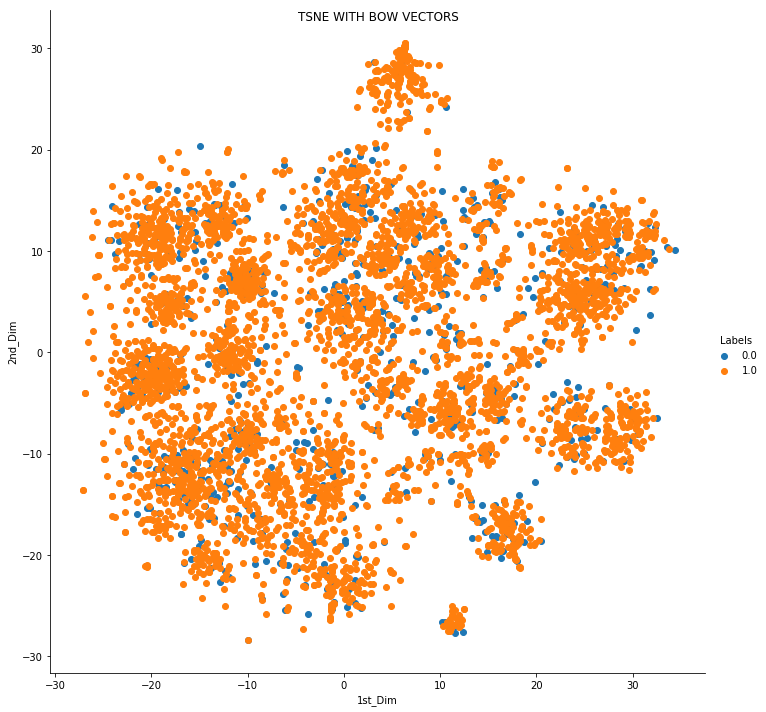

In [112]:
sns.FacetGrid(tsne_df_b, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim")\
.add_legend().\
fig.suptitle("TSNE WITH BOW VECTORS")
plt.show()


Observation - 
We observe a lot of overlapping in the datapoints. The points are well scattered, unable to draw any conclusion from the above graph.

#  5.2) tSNE with tfIDF

In [113]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot, project_grade_categories_one_hot,\
            teacher_prefix_categories_one_hot, price_standardized, quantity_standardized, previous_projects_standardized,\
            title_tfidf))
X.shape

(109248, 5210)

In [114]:
X = X.tocsr()
X_new = X[0:5000,:]

In [115]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_tfidf = model.fit_transform(X_new)

In [116]:
tsne_data_tfidf = np.vstack((tsne_data_tfidf.T, labels_new)).T
tsne_df_tfidf = pd.DataFrame(tsne_data_tfidf, columns = ("1st_Dim","2nd_Dim","Labels"))

In [117]:
tsne_df_tfidf.shape

(5000, 3)

In [118]:
sns.FacetGrid(tsne_df_tfidf, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").\
add_legend().fig.suptitle("TSNE WITH TF-IDF VECTORS")
plt.show()

Observation - 
The Blue and therefore the Orange points don't kind any clusters or accumulation of any type, Therefore drawing conclusions appears to quite not possible with the present state of the T-SNE using TFIDF.


# 5.3) tSNE with Avg W2V

In [119]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot, project_grade_categories_one_hot,\
            teacher_prefix_categories_one_hot, price_standardized, quantity_standardized, previous_projects_standardized,\
            avg_w2v_vectors_titles))
X.shape

(109248, 403)

In [120]:
X = X.tocsr()
X_new = X[0:5000,:]

In [121]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_avg_w2v = model.fit_transform(X_new)

In [122]:
tsne_data_avg_w2v = np.vstack((tsne_data_avg_w2v.T, labels_new)).T
tsne_df_avg_w2v = pd.DataFrame(tsne_data_avg_w2v, columns = ("1st_Dim","2nd_Dim","Labels"))

In [123]:
tsne_df_avg_w2v.shape

(5000, 3)

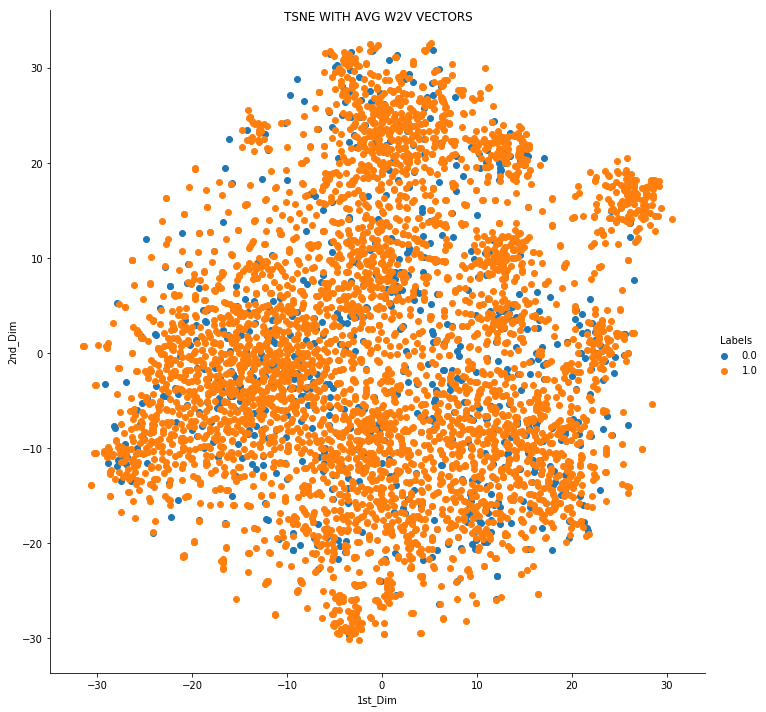

In [124]:
sns.FacetGrid(tsne_df_avg_w2v, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").\
add_legend().\
fig.suptitle("TSNE WITH AVG W2V VECTORS")
plt.show()


Observation - 
We don't observe any clusters for whether the Project is accepted or not accepted. Therefore we tend to don't seem to be able to come through the required result mistreatment Avg- Word2vec

# 5.4) tSNE with tfIDF weighted W2V vectors

In [125]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot, project_grade_categories_one_hot,\
            teacher_prefix_categories_one_hot, price_standardized, quantity_standardized, \
            previous_projects_standardized, tfidf_w2v_vectors_title))
X.shape

(109248, 403)

In [126]:
X = X.tocsr()
X_new = X[0:5000,:]

In [127]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_tfidf_w2v = model.fit_transform(X_new)

In [128]:
tsne_data_tfidf_w2v = np.vstack((tsne_data_tfidf_w2v.T, labels_new)).T
tsne_df_tfidf_w2v = pd.DataFrame(tsne_data_tfidf_w2v, columns = ("1st_Dim","2nd_Dim","Labels"))

In [129]:
tsne_df_tfidf_w2v.shape

(5000, 3)

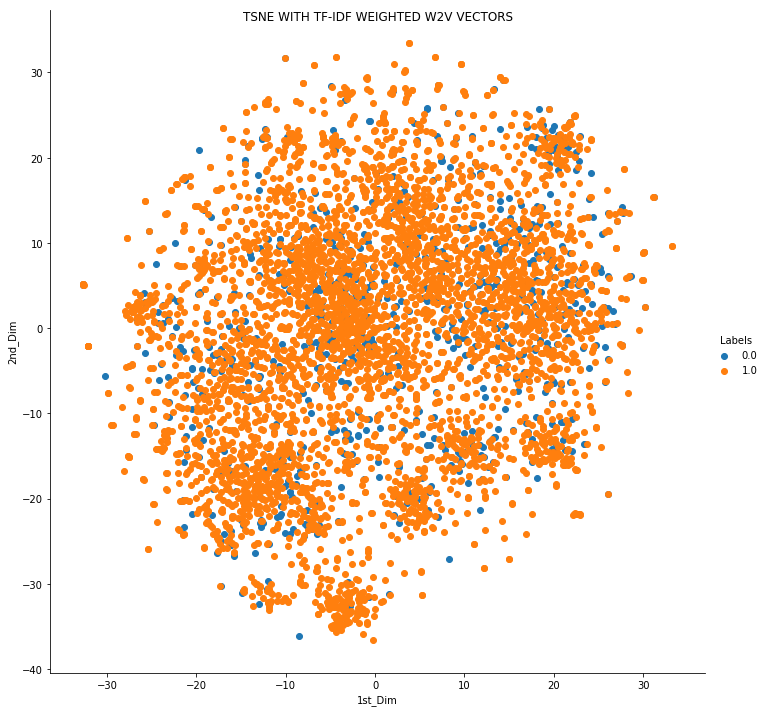

In [130]:
sns.FacetGrid(tsne_df_tfidf_w2v, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").\
add_legend().fig.suptitle("TSNE WITH TF-IDF WEIGHTED W2V VECTORS")
plt.show()

Observation - 
This visualization of TSNE with TF-IDF Weighted Word2Vec does not appear to yield the expected results on bunch of similar data points.

# 5.5) tSNE with 'BoW', 'tfIDF', 'Avg W2V', 'tfIDF weighted W2V' 

In [131]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot, project_grade_categories_one_hot,\
            teacher_prefix_categories_one_hot, price_standardized, quantity_standardized, previous_projects_standardized,\
            title_bow, title_tfidf, avg_w2v_vectors_titles, tfidf_w2v_vectors_title))
X.shape

(109248, 10917)

In [132]:
X = X.tocsr()
X_new = X[0:5000,:]

In [133]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_complete = model.fit_transform(X_new)

In [134]:
tsne_data_complete = np.vstack((tsne_data_complete.T, labels_new)).T
tsne_df_complete = pd.DataFrame(tsne_data_complete, columns = ("1st_Dim","2nd_Dim","Labels"))

In [135]:
tsne_df_complete.shape

(5000, 3)

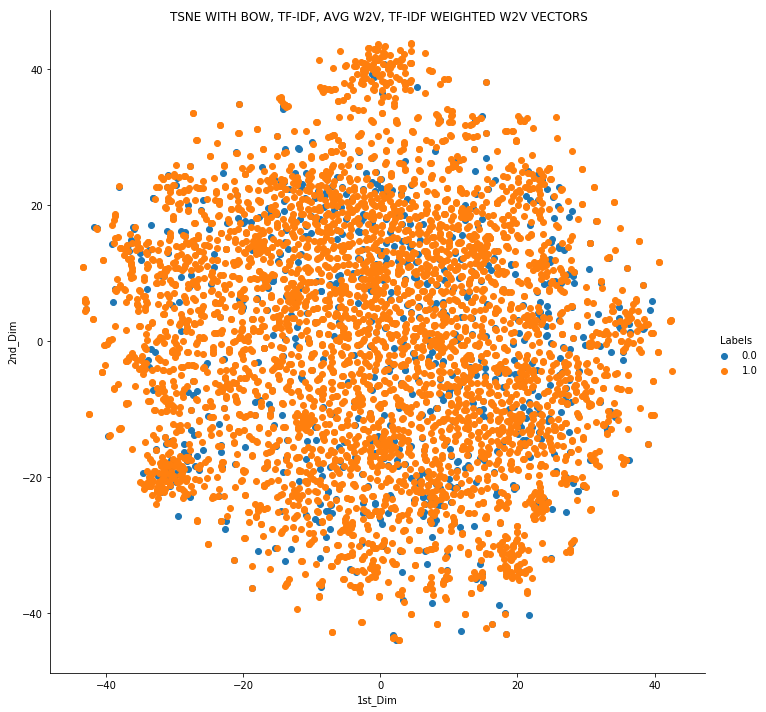

In [136]:
sns.FacetGrid(tsne_df_complete, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").\
add_legend().\
fig.suptitle("TSNE WITH BOW, TF-IDF, AVG W2V, TF-IDF WEIGHTED W2V VECTORS")
plt.show()

Observation- 
This visual image of tSNE with Bag of Words, TF-IDF, Avg Word2Vec, TF-IDF Weighted Word2Vec doesn't appear to yield the expected results of cluster similar data points. Therefore, we might ought to strive the other methodology.


# 6) Conclusion - 

* The majority of the project is endorsed in the state of California(CA) with an average of 85.81% and the lowest in the state of Vermont(VT) with an average of 80.00%. In the average acceptance rate of project approval across countries, we discovered a lot of variability.
* Vermont State (VT) has the smallest proportion of project approvals, i.e. 80%, followed by District of Columbia (DC) with 80.83% and Texas (TX) with 81.31% in the U.S.
* Female teachers have suggested and accepted the highest amount of projects compared with male teachers.
* Between Pre Kindergarden and 2nd Grade, there are many projects suggested for the students while it continues to decline for the remainder.
* Projects belonging to the categories of Literacy and Language have the largest amount of suggested initiatives. This category also includes the highest amount of approved projects, with an acceptance rate of approximately 87%.The largest amount of projects are recorded with 52,239 projects in Literacy and Language, followed by 41,421 projects in Maths and Science.
* With 8371 projects, the Literacy sub-category has the largest amount of projects authorized. The acceptance rate is also 88%.
* Most of the projects are titled with 4 words. Similarly, in most of the project there are also 3 and 5 words. Few of the parts of the project contain 10 words in the name.
* Compared to the Rejected Projects, the amount of Projects authorized has a slightly greater amount of words in the Title. The Box plots use the percentiles while the graph above used densities of probability.
* In project essays, authorized projects have a slightly higher amount of words compared to projects that were not approved. This distinction can be seen in the gap after the 50.0 percentile. The amount of words in the approved project essays is slightly higher than the amount of words in the rejected project essays. This can be observed by looking at the Blue Line (Approved Projects PDF Curve) which is more dense for words than 240 to nearly 480 or 500.
* From the box plot presenting the cost engaged per project, not much can be understood. From the PDF curves, we can generalize that mostly very expensive projects are not generally approved.
* The authorized projects tend to have reduced costs compared to non-approved projects. Looking at the percentile values, this can be noticed. For an approved project, the 50th percentile cost value is 198.99 dollars, while the cost for the unapproved projects is 263.145 dollars.
* We note that a teacher does not have to propose any project beforehand. Teachers with no previous project proposals presented a maximum amount of teachers, almost 82 percent of the authorized projects. There is much appreciation for new talent and attempts.
* The numerical project summaries have a very elevated acceptability rate of 90%. Well, adequate numbered requirements indicate clarity in the suggestions and therefore many individuals tend to donate for a better cause, i.e. helping kids.
* We notice that an average cost almost 298 dollars each project, with a standard deviation of 368 dollars. So, most of the projects are less than 750 dollars.
* On average, projects involve at least 17 different items of the same kind. We note that, in general, the price paid is for buying these items. Donors can choose to donate projects based on the items given to help any Grade students.
* We observe that Teachers usually on a median propose atleast eleven completely different projects. The Teachers area unit so actively seeking facilitate to help for the betterment of the students in their neighborhood.
* This visual image of tSNE with Bag of Words, TF-IDF, Avg Word2Vec, TF-IDF Weighted Word2Vec doesn't appear to yield the expected results of cluster similar data points. Therefore, we might ought to strive the other methodology.